This section of code is the modeling.  Run many times with different features and varying the random_state of the train/test/select eventually yielded a somewhat stable model.  Next steps are to collect more training data (500 observations are probably not enough) and perform more category feature engineering on zip_code and / or legal_subdivision as the location seems to have a more variation than a linear latitude / longitude can predict.

In [1]:
from bs4 import BeautifulSoup
import requests
import time, os
import seaborn as sns
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.linear_model import lars_path
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

Read in dataset and create dummies for categories.

In [2]:
property_df = pd.read_csv('best_final(5).csv')

In [3]:
property_df['Price'] = property_df['Price'].apply(lambda col:pd.to_numeric(col, errors='coerce'))

In [4]:
structure_df = pd.get_dummies(property_df['Structure Type'], drop_first=True)
zip_df = pd.get_dummies(property_df['Zip Code'], drop_first=True)

In [5]:
property_df = property_df.join(structure_df)
property_df = property_df.join(zip_df)

Linear Regression, later augmented by polynomials including interaction terms.

In [6]:
property_df_n = property_df[['Zip Code','Interior Row/Townhouse','Single','Twin/Semi-Detached','Longitude', 'Latitude', 'Year Built', 'Fireplaces Count', 'Levels Count', 'Total SqFt',  'Garage Spaces', 'Tax Total Finished SqFt',  'Bedrooms', 'Bathrooms Total', 'Lot SqFt', 'Price', 'Status']]

In [7]:
# Let's jump right in and try a model using all variables above 0.6 correlation

property_df_ntr = property_df_n.loc[property_df_n['Status'].str.contains('Sold|OFF MARKET', case=False)]


X = property_df_ntr[['Zip Code','Longitude', 'Levels Count', 'Total SqFt','Bathrooms Total', 'Interior Row/Townhouse','Single','Twin/Semi-Detached']]
y = property_df_ntr['Price']

poly = PolynomialFeatures(2)
Xp = poly.fit_transform(X)

names = poly.get_feature_names(X.columns)
X2 = pd.DataFrame(Xp, columns = names)
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   1                                          415 non-null    float64
 1   Zip Code                                   415 non-null    float64
 2   Longitude                                  415 non-null    float64
 3   Levels Count                               415 non-null    float64
 4   Total SqFt                                 415 non-null    float64
 5   Bathrooms Total                            415 non-null    float64
 6   Interior Row/Townhouse                     415 non-null    float64
 7   Single                                     415 non-null    float64
 8   Twin/Semi-Detached                         415 non-null    float64
 9   Zip Code^2                                 415 non-null    float64
 10  Zip Code Longitude        

In [8]:
X = X2[['Total SqFt Twin/Semi-Detached','Total SqFt Bathrooms Total','Levels Count Total SqFt','Longitude^2','Bathrooms Total','Total SqFt','Total SqFt Interior Row/Townhouse','Zip Code','Levels Count Twin/Semi-Detached']]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=70)
X_tr, X_v, y_tr, y_v = train_test_split(X_tr, y_tr, test_size=0.25, random_state=70)

In [9]:
# Instantiate your model
lr = LinearRegression()

# Fit
lr.fit(X_tr,y_tr)

LinearRegression()

In [10]:
# Print out the coefficients and intercept
print(lr.coef_)
print(lr.intercept_)

[-1.86957130e+02  2.20434519e+00  1.98928304e+01  2.50844148e+04
  1.44299714e+05  8.86698345e+01  5.97670223e+00 -1.71164395e+02
  8.74333611e+04]
-145128494.07760426


Calculate errors and plot results

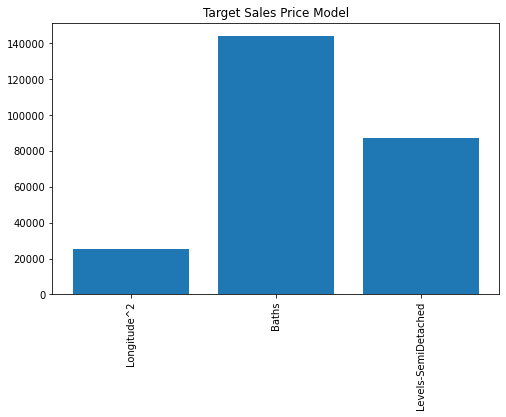

In [11]:
plt.figure(figsize=[8,5])
plt.title('Target Sales Price Model')
ticks_x = np.linspace(0, 2, 3)
plt.xticks(ticks_x, labels=('Longitude^2','Baths','Levels-SemiDetached'), rotation='vertical', fontsize='10');
plt.legend
plt.bar(height=[25084.4148, 144299.714, 87433.3611],x=['Longitude^2','Baths','Levels-SemiDetached']); 
# # plt.savefig('JAMAICA 179 ST', bbox_inches="tight") 

In [12]:
# Now score your model with R^2
print(lr.score(X_tr, y_tr))

0.7239449120067258


In [13]:
# Now score your model with R^2
print(lr.score(X_v, y_v))

0.645608357640872


In [14]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_tr)

StandardScaler()

In [15]:
## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_trs = std.transform(X_tr)

In [16]:
lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_trs,y_tr)

Lasso(alpha=10000)

In [17]:
# These are the (standardized) coefficients found
# when it refit using that best alpha

list(zip(X_tr, lasso_model.coef_))

[('Total SqFt Twin/Semi-Detached', -21741.158561179534),
 ('Total SqFt Bathrooms Total', 17318.57030527816),
 ('Levels Count Total SqFt', 117990.19326509195),
 ('Longitude^2', 142780.000256303),
 ('Bathrooms Total', 170360.43090159513),
 ('Total SqFt', 107115.92662713856),
 ('Total SqFt Interior Row/Townhouse', 0.0),
 ('Zip Code', -93991.93864840803),
 ('Levels Count Twin/Semi-Detached', -0.0)]

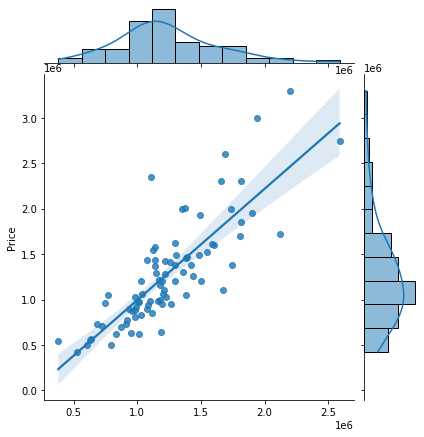

In [18]:
preds_v = lr.predict(X_v) # generate predictions (on training data) using fit model
preds_tr = lr.predict(X_tr) 
preds_te = lr.predict(X_te)
sns.jointplot(x=preds_v,y=y_v, kind='reg')

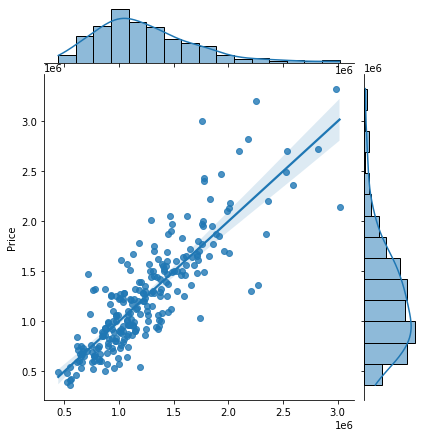

In [19]:
sns.jointplot(x=preds_tr,y=y_tr, kind='reg')

In [20]:
print(np.mean(np.abs(y_tr-preds_tr)))

204427.61567731854


In [21]:
print(np.mean(np.abs(y_v-preds_v)))

236889.1266153329


In [22]:
print(np.mean(np.abs(y_te-preds_te)))

209243.4239336737


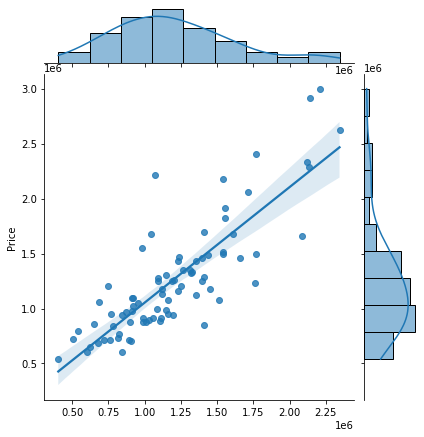

In [23]:
sns.jointplot(x=preds_te,y=y_te, kind='reg')

In [24]:
print(lr.score(X_tr, y_tr))
print(lr.score(X_v, y_v))
print(lr.score(X_te, y_te))

0.7239449120067258
0.645608357640872
0.6790033167330582


Run the prediction dataset through the Sales Price Model to get the Target Price.

In [25]:
property_df_predict = property_df.loc[property_df_n['Status'].str.contains('Contingent|Contract|For Sale', case=False)]
Xpr = property_df_predict[['Zip Code','Longitude', 'Levels Count', 'Total SqFt','Bathrooms Total', 'Interior Row/Townhouse','Single','Twin/Semi-Detached']]
y_price = property_df_predict['Price']

poly = PolynomialFeatures(2)
Xprp = poly.fit_transform(Xpr)

names = poly.get_feature_names(Xpr.columns)
X2pr = pd.DataFrame(Xprp, columns = names)
X_predict = X2pr[['Total SqFt Twin/Semi-Detached','Total SqFt Bathrooms Total','Levels Count Total SqFt','Longitude^2','Bathrooms Total','Total SqFt','Total SqFt Interior Row/Townhouse','Zip Code','Levels Count Twin/Semi-Detached']]

In [26]:
y_predict = lr.predict(X_predict)

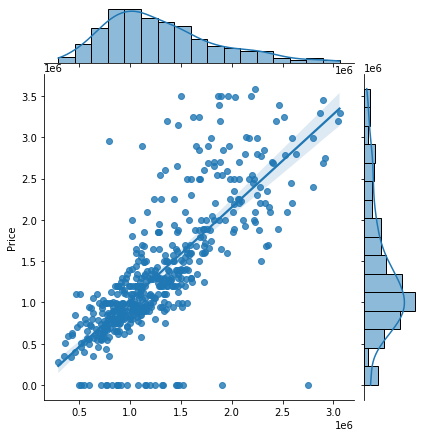

In [27]:
sns.jointplot(x=y_predict,y=y_price, kind='reg')

In [28]:
property_df_predict_price = property_df_predict
property_df_predict_price['Target Price'] = y_predict
property_df_predict_price.to_csv('predictions.csv')

/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_7172/1998612250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_df_predict_price['Target Price'] = y_predict
